In [1]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt
import os


from pyspecter.SPECTER import SPECTER
from pyspecter.Observables import Observable
# from pyspecter.SpecialObservables import SpecialObservables

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles
# from pyspecter.utils.plot_utils import newplot, plot_event, hist_with_errors, hist_with_outline, stamp
from rikabplotlib.plot_utils import newplot, hist_with_errors, hist_with_outline, plot_event, stamp


# SPECTER
from pyspecter.SpectralEMD_Helper import compute_spectral_representation

2024-03-20 18:15:33.092166: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
random_seed = 0
np.random.seed(random_seed)

# CMS Open Sim Parameters
R = 0.5
pt_lower = 475
pt_upper = 525
eta_cut = 1.9
quality = 2
pad = 100 # Note that runtime is pad^2, memory is pad^4

dataset = "CMS"
n_samples = 500 * 2 # CMS Open Sim Parameters
R = 0.5
pt_lower = 475
pt_upper = 525
eta_cut = 1.9
quality = 2
pad = 10 # Note that runtime is pad^2, memory is pad^4
batch_size = 1 # Number of pairs to process in parallel, can probably be increased.

if dataset == "CMS":

    # Load data -- this will take a while the first time. Downloads the data from the CMS Open Data portal. Sub in your own data if you have if you want.
    dataset, sim_weights, k_factors = load_cmsopendata("~/.energyflow/", "sim", pt_lower, pt_upper, eta_cut, quality, pad = pad, n = 1000000, amount=1)
    weights = sim_weights * k_factors

    print("Loaded dataset with {} events".format(len(dataset)))
    print("Trimmig to {} events".format(n_samples)  )
    shuffle = np.random.permutation(len(dataset),)[:n_samples]
    dataset = dataset[shuffle]
    weights = weights[shuffle]



elif dataset == "Random Points":

    dataset, weights = random_triangles(n_samples, R)



# Split dataset into 2 halves
dataset1 = dataset[:n_samples//2]
dataset2 = dataset[n_samples//2:]
weights1 = weights[:n_samples//2]
weights2 = weights[n_samples//2:]


Max # of particles: 146
Loaded dataset with 46166 events
Trimmig to 1000 events


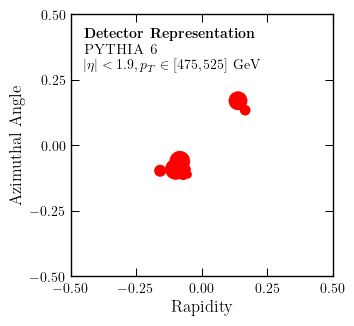

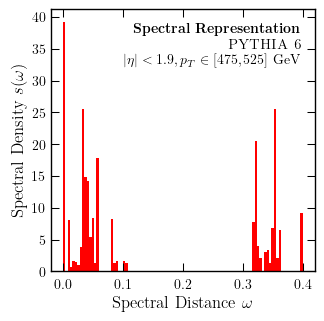

In [3]:
# Figure 1: Detector Representation

fig, ax = newplot("column")
plot_event(ax, dataset1[1], 0.5)

line_0 = r"Detector Representation"
line_1 = r"$\textsc{PYTHIA 6}$"
line_2 = r"$|\eta| < 1.9, p_T \in [475, 525]$ GeV"
stamp(0.05, 0.925, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2)

plt.savefig("Plots/detector_representation.pdf", bbox_inches="tight")

# Figure 2: Spectral Representation

spectral_repesentation = compute_spectral_representation(dataset1[1], )
fig, ax = newplot("column")
plt.hist(spectral_repesentation[:,0], bins=100, histtype="stepfilled", weights = spectral_repesentation[:,1], density=True, color="red", label="Spectral Representation")
plt.xlabel(r"Spectral Distance $\omega$")
plt.ylabel(r"Spectral Density $s(\omega)$")

line_0 = r"Spectral Representation"
line_1 = r"$\textsc{PYTHIA 6}$"
line_2 = r"$|\eta| < 1.9, p_T \in [475, 525]$ GeV"
stamp(0.95, 0.925, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"ha" : "right"})

plt.savefig("Plots/spectral_representation.pdf", bbox_inches="tight")

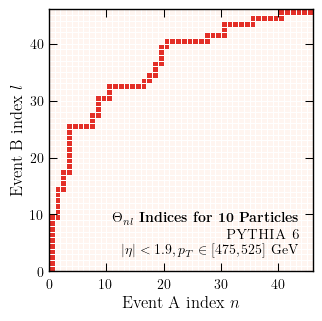

In [49]:
from pyspecter.SpectralEMD_Helper import find_indices, find_indices_jax

spectral_2 = compute_spectral_representation(dataset1[1])
spectral_1 = compute_spectral_representation(dataset1[2])

cumulative_1 = np.cumsum(spectral_1[:,1])
cumulative_2 = np.cumsum(spectral_2[:,1])


indices, mask = find_indices(cumulative_1, cumulative_2)

# Make matrix of indices: (i,j) pixel is colored only if it is in indices
indices_matrix = np.zeros((len(cumulative_1), len(cumulative_2)))
indices_matrix[indices[:,0], indices[:,1]] = 1
indices_matrix = indices_matrix.T


# Figure 3: 2D histogram where the (i,j) pixel is colored only if it is in indices
fig, ax = newplot("column")


# colors so that if the matrix is 1, it is bright red, if it is 0, it is white



plt.pcolormesh(indices_matrix, cmap = "Reds", vmax= 1.5, edgecolors="white", linewidth=0.5)
# plt.xlim(0.5, len(cumulative_2))
# plt.ylim(0.5, len(cumulative_1))

plt.xlabel(r"Event A index $n$")
plt.ylabel(r"Event B index $l$")


line_0 = r"$\Theta_{nl}$ Indices for 10 Particles"
line_1 = r"$\textsc{PYTHIA 6}$"
line_2 = r"$|\eta| < 1.9, p_T \in [475, 525]$ GeV"
stamp(0.95, 0.2, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"ha" : "right"})

print()

# Major ticks
size = len(cumulative_2) 
# ax.set_xticks(np.arange(0, size, 10))
# ax.set_yticks(np.arange(0, size, 10))

# # # Labels for major ticks
# ax.set_xticklabels(np.arange(1, size + 1, 10))
# ax.set_yticklabels(np.arange(1, size + 1, 10))

# # Minor ticks
# ax.set_xticks(np.arange(0, size + 0, 1), minor=True)
# ax.set_yticks(np.arange(0, size + 0, 1), minor=True)

# # Gridlines based on minor ticks
# ax.grid(which='minor', color='blue', linestyle='-', linewidth=0.5)
# ax.grid(which='major', color='blue', linestyle='-', linewidth=0.5)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)

plt.savefig("Plots/theta_indices.pdf", bbox_inches="tight")



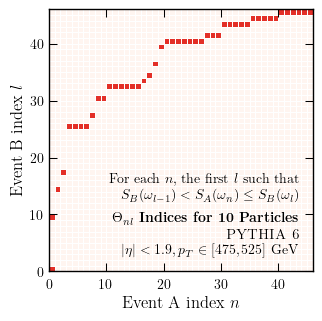

In [46]:
import jax.numpy as jnp

X, Y = cumulative_1, cumulative_2

j_indices = jnp.searchsorted(Y, X, side = 'left')
i_indices = jnp.searchsorted(X, Y, side = 'left')

# i indices
pairs = jnp.zeros((X.shape[0] + Y.shape[0], 2), dtype=int)
pairs = pairs.at[0:X.shape[0], 0].set(jnp.arange(X.shape[0]))
pairs = pairs.at[0:X.shape[0], 1].set(j_indices)
# pairs = pairs.at[X.shape[0]:X.shape[0] + Y.shape[0], 0].set(i_indices)
# pairs = pairs.at[X.shape[0]:X.shape[0] + Y.shape[0], 1].set(jnp.arange(Y.shape[0]))

indices_matrix_i = np.zeros((len(cumulative_1), len(cumulative_2)))
indices_matrix_i[pairs[:,0], pairs[:,1]] = 1
indices_matrix_i = indices_matrix_i.T

fig, ax_i = newplot("column")
plt.pcolormesh(indices_matrix_i, cmap = "Reds", vmax= 1.5, edgecolors="white", linewidth=0.5)
# plt.xlim(0, len(cumulative_2))
# plt.ylim(0, len(cumulative_1))

plt.xlabel(r"Event A index $n$")
plt.ylabel(r"Event B index $l$")


text_0 = r"For each $n$, the first $l$ such that"
text_1 = r"$S_B(\omega_{l-1}) < S_A(\omega_n) \leq S_B(\omega_l)$"
stamp(0.95, 0.35, ax_i, line_0 = text_0, line_1 = text_1, textops_update={"ha" : "right"}, boldfirst=False)

line_0 = r"$\Theta_{nl}$ Indices for 10 Particles"
line_1 = r"$\textsc{PYTHIA 6}$"
line_2 = r"$|\eta| < 1.9, p_T \in [475, 525]$ GeV"
stamp(0.95, 0.2, ax_i, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"ha" : "right"})

plt.savefig("Plots/theta_indices_j.pdf", bbox_inches="tight")


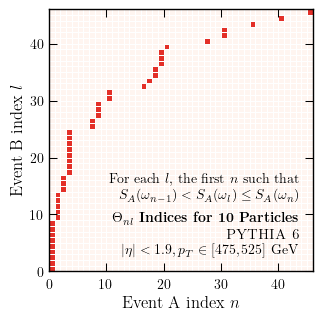

In [47]:
import jax.numpy as jnp

X, Y = cumulative_1, cumulative_2

j_indices = jnp.searchsorted(Y, X, side = 'left')
i_indices = jnp.searchsorted(X, Y, side = 'left')

# i indices
pairs = jnp.zeros((X.shape[0] + Y.shape[0], 2), dtype=int)
# pairs = pairs.at[0:X.shape[0], 0].set(jnp.arange(X.shape[0]))
# pairs = pairs.at[0:X.shape[0], 1].set(j_indices)
pairs = pairs.at[X.shape[0]:X.shape[0] + Y.shape[0], 0].set(i_indices)
pairs = pairs.at[X.shape[0]:X.shape[0] + Y.shape[0], 1].set(jnp.arange(Y.shape[0]))

indices_matrix_j = np.zeros((len(cumulative_1), len(cumulative_2)))
indices_matrix_j[pairs[:,0], pairs[:,1]] = 1
indices_matrix_j = indices_matrix_j.T

fig, ax_j = newplot("column")
plt.pcolormesh(indices_matrix_j, cmap = "Reds", vmax= 1.5, edgecolors="white", linewidth=0.5)


plt.xlabel(r"Event A index $n$")
plt.ylabel(r"Event B index $l$")


text_0 = r"For each $l$, the first $n$ such that"
text_1 = r"$S_A(\omega_{n-1}) < S_A(\omega_l) \leq S_A(\omega_n)$"
stamp(0.95, 0.35, ax_j, line_0 = text_0, line_1 = text_1, textops_update={"ha" : "right"}, boldfirst=False)

line_0 = r"$\Theta_{nl}$ Indices for 10 Particles"
line_1 = r"$\textsc{PYTHIA 6}$"
line_2 = r"$|\eta| < 1.9, p_T \in [475, 525]$ GeV"
stamp(0.95, 0.2, ax_j, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"ha" : "right"})

plt.savefig("Plots/theta_indices_i.pdf", bbox_inches="tight")


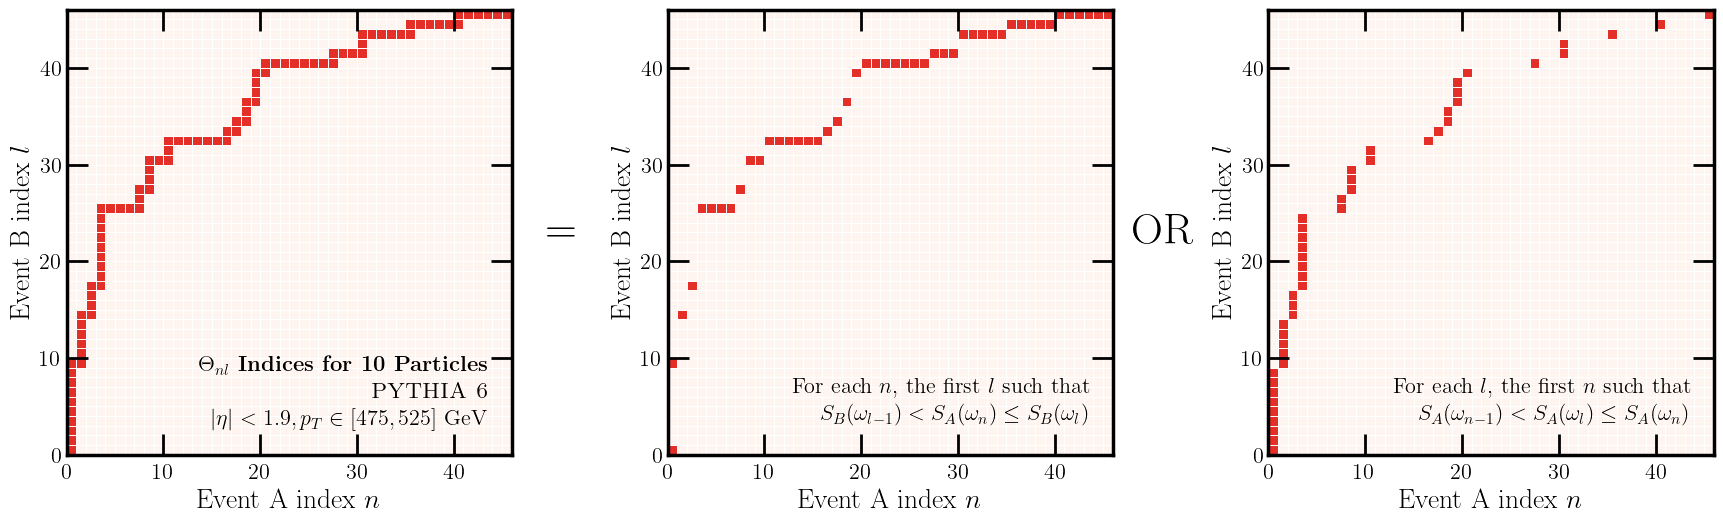

In [72]:
# Load the previous 3 plots (PDF) and make a 3x1 plot in a row

fig, ax = newplot("full", subplot_array=(1,3), aspect_ratio=1/3)

ax[0].pcolormesh(indices_matrix, cmap = "Reds", vmax= 1.5, edgecolors="white", linewidth=0.5)
ax[0].set_xlabel(r"Event A index $n$")
ax[0].set_ylabel(r"Event B index $l$")
ax[0].set_aspect("equal")

ax[1].pcolormesh(indices_matrix_i, cmap = "Reds", vmax= 1.5, edgecolors="white", linewidth=0.5)
ax[1].set_xlabel(r"Event A index $n$")
ax[1].set_ylabel(r"Event B index $l$")
ax[1].set_aspect("equal")

ax[2].pcolormesh(indices_matrix_j, cmap = "Reds", vmax= 1.5, edgecolors="white", linewidth=0.5)
ax[2].set_xlabel(r"Event A index $n$")
ax[2].set_ylabel(r"Event B index $l$")
ax[2].set_aspect("equal")


# Increase space between subplots
plt.subplots_adjust(wspace=0.35)


# Text 
line_0 = r"$\Theta_{nl}$ Indices for 10 Particles"
line_1 = r"$\textsc{PYTHIA 6}$"
line_2 = r"$|\eta| < 1.9, p_T \in [475, 525]$ GeV"
stamp(0.95, 0.2, ax[0], line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"ha" : "right"})


text_0 = r"For each $n$, the first $l$ such that"
text_1 = r"$S_B(\omega_{l-1}) < S_A(\omega_n) \leq S_B(\omega_l)$"
stamp(0.95, 0.15, ax[1], line_0 = text_0, line_1 = text_1, textops_update={"ha" : "right"}, boldfirst=False)

text_0 = r"For each $l$, the first $n$ such that"
text_1 = r"$S_A(\omega_{n-1}) < S_A(\omega_l) \leq S_A(\omega_n)$"
stamp(0.95, 0.15, ax[2], line_0 = text_0, line_1 = text_1, textops_update={"ha" : "right"}, boldfirst=False)

# Between subplots 0 and 1, add text
text_0 = r"For each $n$, the first $l$ such that"
text_1 = r"$S_B(\omega_{l-1}) < S_A(\omega_n) \leq S_B(\omega_l)$"
stamp(1.15, 0.5, ax[0], line_0 = "=", textops_update={"ha" : "right", "fontsize" : 32}, boldfirst=False)
stamp(1.185, 0.5, ax[1], line_0 = "OR", textops_update={"ha" : "right", "fontsize" : 32}, boldfirst=False)

plt.savefig("Plots/theta_indices_all.pdf", bbox_inches="tight")
